In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ppe-dataset-yolov8/README.dataset.txt
/kaggle/input/ppe-dataset-yolov8/README.roboflow.txt
/kaggle/input/ppe-dataset-yolov8/data.yaml
/kaggle/input/ppe-dataset-yolov8/valid/labels/packing212_jpg.rf.62162c82bc7de00746a33e725d45df08.txt
/kaggle/input/ppe-dataset-yolov8/valid/labels/image_48_jpg.rf.e2d6f5d2be2d72b68d292599a11fcebb.txt
/kaggle/input/ppe-dataset-yolov8/valid/labels/image_187_jpg.rf.704d557a0bc1f89bc45dbce570e1b96e.txt
/kaggle/input/ppe-dataset-yolov8/valid/labels/-4430-_png_jpg.rf.efdf15f450e5ab5890f25cd027bcd37e.txt
/kaggle/input/ppe-dataset-yolov8/valid/labels/-1318-_png_jpg.rf.767d9b6565d37e4bb233d674450bf8a0.txt
/kaggle/input/ppe-dataset-yolov8/valid/labels/-3500-_png_jpg.rf.dfdf3251c40e677e8fb08b11002d9142.txt
/kaggle/input/ppe-dataset-yolov8/valid/labels/people-2048-_jpg.rf.1aef225ea16068748471f90823b5ff1a.txt
/kaggle/input/ppe-dataset-yolov8/valid/labels/-4589-_png_jpg.rf.94495fc73384b667a3cada92dce77a54.txt
/kaggle/input/ppe-dataset-yolov8/valid/labels

In [2]:
!pip install --upgrade ultralytics
!pip install --upgrade -U ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

%matplotlib inline

!wandb disabled

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
W&B disabled.


In [13]:
class CFG:
    DEBUG = False  # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    # classes
    CLASSES = ['Dust Mask']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 5  # 100
    BATCH_SIZE = 8

    BASE_MODEL = 'yolov9e'  # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = "AdamW"  # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-5
    DROPOUT = 0.2
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.1

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/ppe-dataset-yolov8'
    OUTPUT_DIR = '/kaggle/working/'

In [5]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
}

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [6]:
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Dust Mask
nc: 1
test: /kaggle/input/ppe-dataset-yolov8/test
train: /kaggle/input/ppe-dataset-yolov8/train
val: /kaggle/input/ppe-dataset-yolov8/valid



In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def display_image(image_path, print_info=True, hide_axis=False):
    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Error: The file {image_path} does not exist.")
        return

    # Open the image
    img = Image.open(image_path)

    # Print image info if needed
    if print_info:
        print(f"Image Path: {image_path}")
        print(f"Image Size: {img.size}")
        print(f"Image Mode: {img.mode}")

    # Display the image
    plt.imshow(img)
    if hide_axis:
        plt.axis('off')
    plt.show()

Image Path: /kaggle/input/ppe-dataset-yolov8/train/images/-1080-_png_jpg.rf.cb5f2842f02d43b900e066defa9bbd7e.jpg
Image Size: (640, 640)
Image Mode: RGB


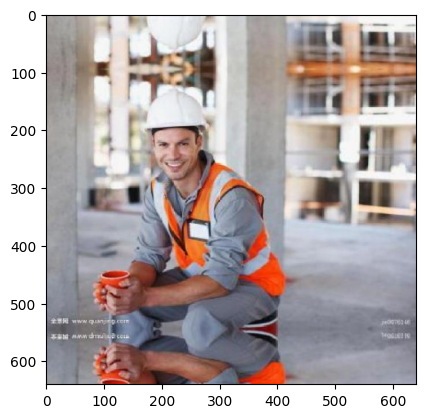

In [10]:
example_image_path = '/kaggle/input/ppe-dataset-yolov8/train/images/-1080-_png_jpg.rf.cb5f2842f02d43b900e066defa9bbd7e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

In [11]:
# Function to get image properties after resizing
def get_image_properties(image_path, new_size=(640, 640)):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Resize the image to the new size
    img_resized = cv2.resize(img, new_size)

    # Get resized image properties
    properties = {
        "width": img_resized.shape[1],  # Width of resized image
        "height": img_resized.shape[0],  # Height of resized image
        "channels": img_resized.shape[2] if len(img_resized.shape) == 3 else 1,  # Number of channels (1 for grayscale, 3 for RGB)
        "dtype": img_resized.dtype  # Data type of the image
    }

    return properties, img_resized  # Return both properties and resized image

In [12]:
img_properties, img_resized = get_image_properties(example_image_path, new_size=(640, 640))
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [18]:
class_idx = [str(i) for i in range(CFG.NUM_CLASSES_TO_TRAIN)]

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}
    
    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

        for cls in set([line.split()[0] for line in lines]):
            class_count[class_idx[int(cls)]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)

with pd.option_context('display.max_columns', None):
    display(dataset_stats_df)

IndexError: list index out of range

In [19]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
    # device = [0,1],  # inference with dual GPU
    device = None,     # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

100%|██████████| 112M/112M [00:00<00:00, 134MB/s] 



image 1/1 /kaggle/input/ppe-dataset-yolov8/train/images/-1080-_png_jpg.rf.cb5f2842f02d43b900e066defa9bbd7e.jpg: 640x640 1 person, 3314.9ms
Speed: 7.6ms preprocess, 3314.9ms inference, 22.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Image Path: runs/detect/predict/-1080-_png_jpg.rf.cb5f2842f02d43b900e066defa9bbd7e.jpg
Image Size: (640, 640)
Image Mode: RGB


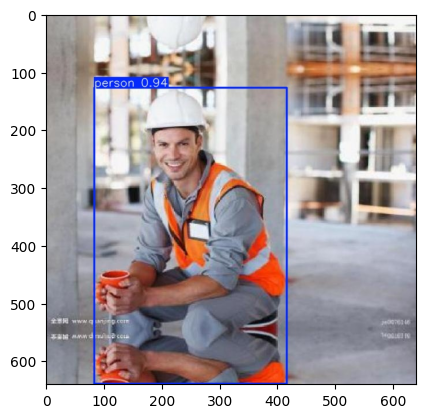

In [20]:
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

In [21]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [22]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import torch

In [ ]:
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    # device = [0],  # use GPU
    # device = None,  # use CPU
    verbose = False,
)

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.120 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/kaggle/working/data.yaml, epochs=5, time=None, patience=20, batch=8, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov9e_ppe_css_5_epochs, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=F

100%|██████████| 755k/755k [00:00<00:00, 12.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  torch.nn.modules.linear.Identity             []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  7                  -1  1   4006912  ultralytics

train: Scanning /kaggle/input/ppe-dataset-yolov8/train/labels... 25675 images, 661 backgrounds, 23926 corrupt:  83%|████████▎ | 25675/30765 [01:58<00:23, 212.92it/s]

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()